# Demo Using the Unwrapped Sprite Datasets

In [1]:
import matplotlib.pyplot as plt
import random

from poke_sprite_dataset.datasets.gen_v_sprites import (
    GenVUnwrappedSprites, 
    ConditionalGenVUnwrappedSprites, 
    int_to_type, 
    int_to_color
)
from torchvision.utils import make_grid

In [2]:
DATA_DIR = '/home/kyle/projects/pokemon_data/data'

sprites_shiny = GenVUnwrappedSprites(
    data_dir=DATA_DIR,
    get_shiny=True,
)

sprites_no_shiny = GenVUnwrappedSprites(
    data_dir=DATA_DIR ,
    get_shiny=False,
)

print('Samples with Shiny:\t', len(sprites_shiny))
print('Samples without Shiny:\t', len(sprites_no_shiny))

Samples with Shiny:	 110100
Samples without Shiny:	 56065


<Figure size 3200x1600 with 0 Axes>

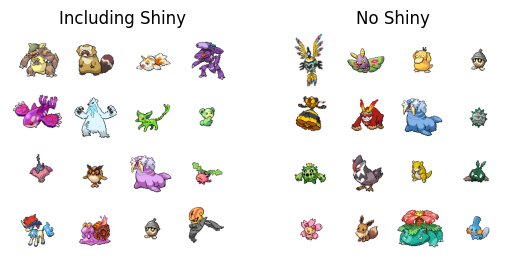

In [3]:
shiny_sample_idx = random.sample(range(len(sprites_shiny)), 16)
no_shiny_sample_idx = random.sample(range(len(sprites_no_shiny)), 16)

shiny_grid = make_grid([sprites_shiny[i][:4, :, :] for i in shiny_sample_idx], nrow=4)
no_shiny_grid = make_grid([sprites_no_shiny[i][:4, :, :] for i in no_shiny_sample_idx], nrow=4)

plt.figure(figsize=(32, 16))
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(shiny_grid.permute(1, 2, 0))
axs[0].set_title('Including Shiny')
axs[0].axis('off')

axs[1].imshow(no_shiny_grid.permute(1, 2, 0))
axs[1].set_title('No Shiny')
axs[1].axis('off')

plt.show()

## Conditional Dataset

In [4]:
cond_dataset = ConditionalGenVUnwrappedSprites(DATA_DIR, get_shiny=True)

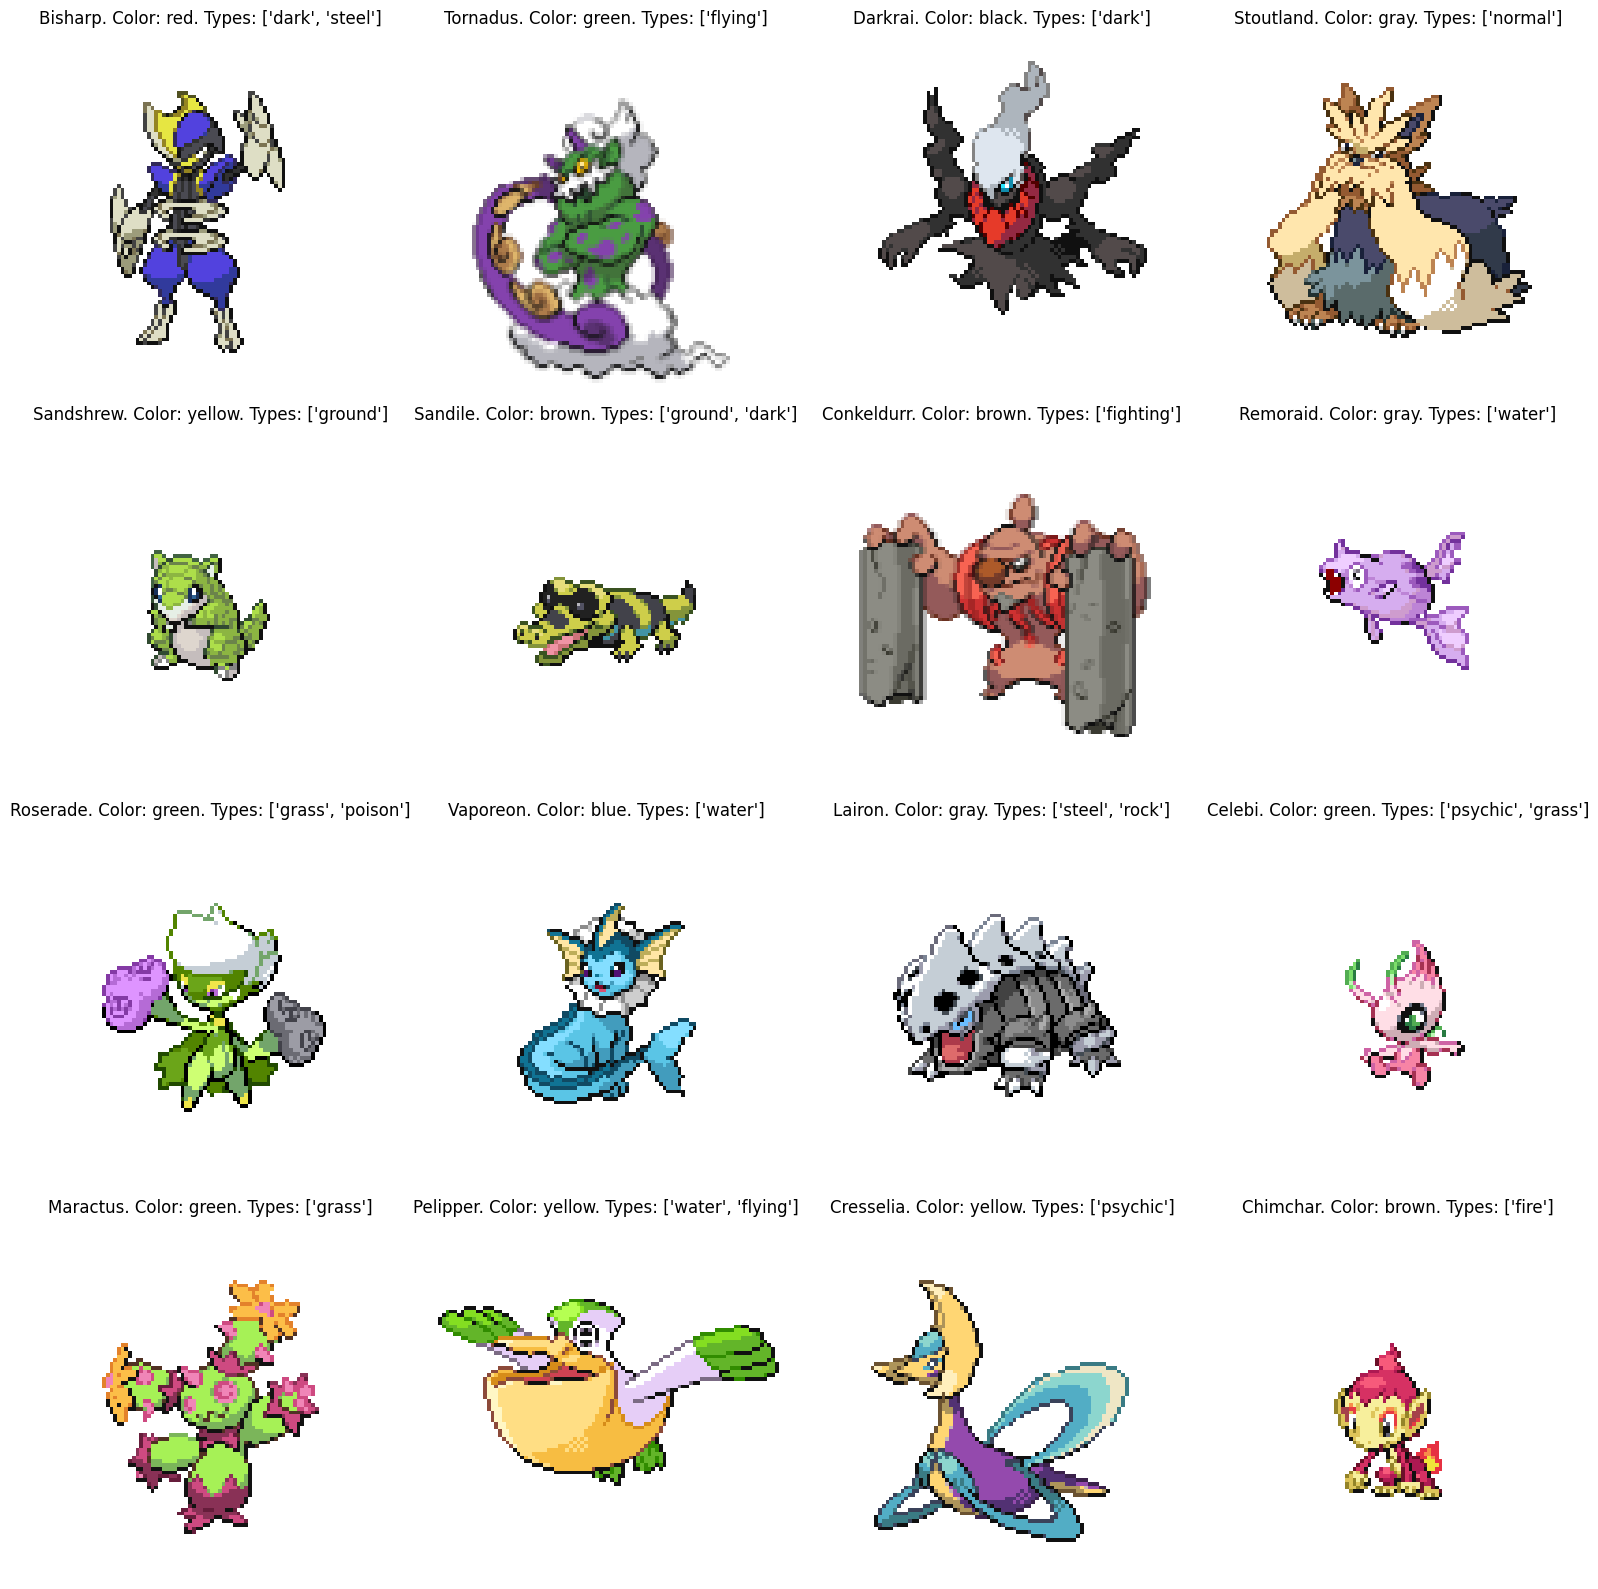

In [5]:
cond_idxs = random.sample(range(len(cond_dataset)), 16)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for n, idx in enumerate(cond_idxs):
    i, j = n // 4, n % 4

    sprite, cond_data = cond_dataset[idx]

    types = [int_to_type(t) for t in cond_data['types']]
    color = int_to_color(cond_data['color'])

    axs[i][j].imshow(sprite.permute(1, 2, 0))
    axs[i][j].set_title(f"{cond_data['name'].title()}. Color: {color}. Types: {types}")
    axs[i][j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
cond_data

{'name': 'chimchar',
 'is_legendary': False,
 'is_mythical': False,
 'color': 2,
 'shape': '6',
 'types': [9],
 'is_shiny': True}

# Statistical Properties

Pixel art tends to have very high frequency components.

Pysteps configuration file found at: /home/kyle/miniconda3/envs/blended_diffusion_2/lib/python3.10/site-packages/pysteps/pystepsrc



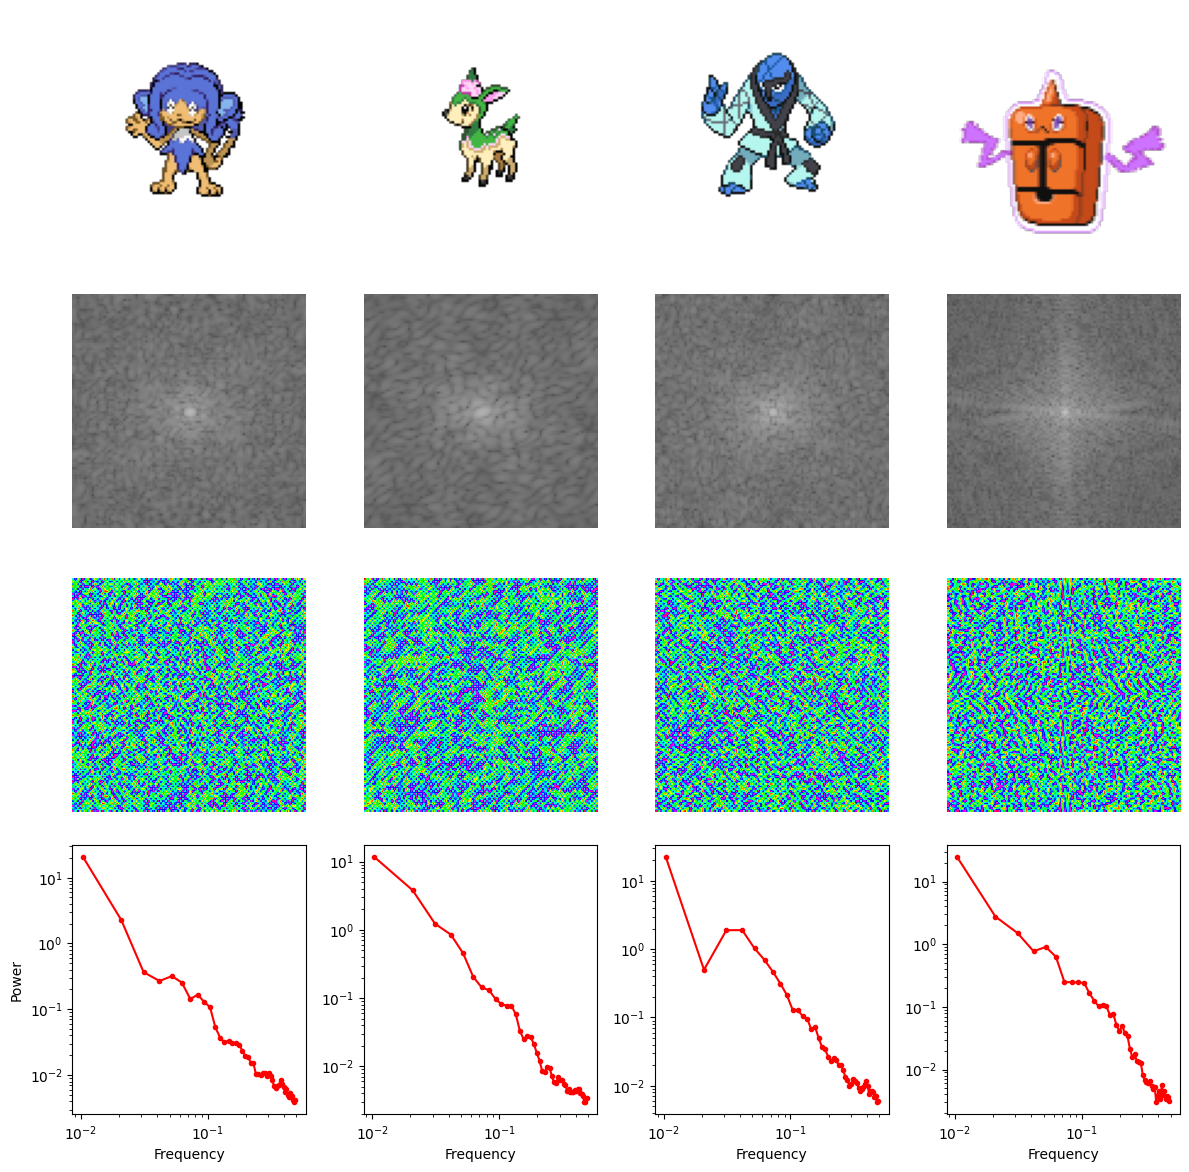

In [7]:
import torch
import numpy as np
from pysteps.utils import spectral

samples = 4

plt.figure(figsize=(3 * samples, 3 * 4))
images = []

for ii in range(samples):
    img = cond_dataset[random.randint(0, len(cond_dataset) - 1)][0]
    plt.subplot(4, samples, ii + 1)
    img = img.permute(1, 2, 0)
    images.append(img)
    plt.imshow(img.detach().cpu())
    plt.axis('off')

images = np.array([img.numpy() for img in images])

for ii in range(samples):
    spectrum = np.fft.fft2(images[ii, ..., 1])
    spectrum = np.fft.fftshift(spectrum)

    plt.subplot(4, samples, samples + ii + 1)
    plt.imshow(np.log(np.abs(spectrum) + 1), vmin=-5, vmax=11, cmap='gray')
    plt.axis('off')

    plt.subplot(4, samples, 2 * samples + ii + 1)
    plt.imshow(np.angle(spectrum), cmap='hsv')
    plt.axis('off')

    plt.subplot(4, samples, 3 * samples + ii + 1)
    rapsd, freq = spectral.rapsd(images[ii, ..., 1], fft_method=np.fft, return_freq=True)
    plt.plot(freq[1:], rapsd[1:], c='red', marker='o', markersize=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency')
    if ii == 0:
        plt.ylabel('Power')
    
plt.tight_layout()
plt.show()

We fit the RAPSD curves as linear power laws.

In [9]:
def calc_mean_log_rapsd(x, num_samples):
  spectra = []
  for k in range(num_samples):
    rapsd, freq = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  var_log_rapsd = np.var(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, var_log_rapsd, freq

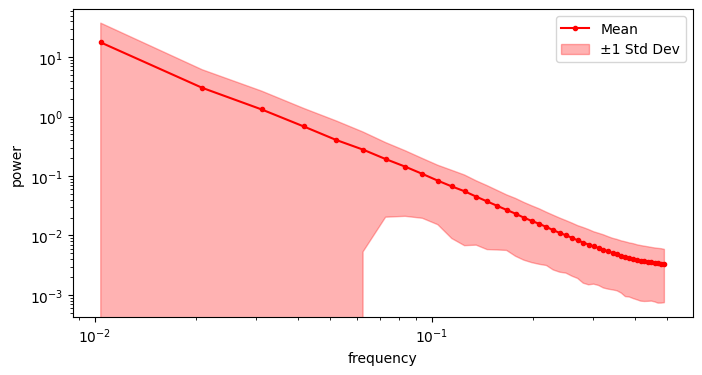

In [24]:
rapsd_samples = 2000
rapsd_images = []

for ii in range(rapsd_samples):
    img = cond_dataset[random.randint(0, len(cond_dataset) - 1)][0]
    img = img.permute(1, 2, 0)
    rapsd_images.append(img)

rapsd_images = np.array([img.numpy() for img in rapsd_images])

mean_log_rapsd, var_log_rapsd, frequencies = calc_mean_log_rapsd(rapsd_images[..., 1], num_samples=rapsd_samples)
std_log_rapsd = np.sqrt(var_log_rapsd)

plt.figure(figsize=(8, 4))
mean_curve = np.exp(mean_log_rapsd)[1:]
std_curve = np.exp(mean_log_rapsd + std_log_rapsd)[1:] - mean_curve
plt.plot(frequencies[1:], mean_curve, c='red', marker='o', markersize=3, label='Mean')
plt.fill_between(frequencies[1:], mean_curve - std_curve, mean_curve + std_curve, color='red', alpha=0.3, label='±1 Std Dev')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power')
plt.legend()

### Average RGB Variance 

In [15]:
import random
import numpy as np

num_samples = 2000

selected_images = []
for _ in range(num_samples):
    img = cond_dataset[random.randint(0, len(cond_dataset) - 1)][0]
    img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    selected_images.append(img.numpy())

selected_images = np.array(selected_images)

variance_r = np.var(selected_images[..., 0])
variance_g = np.var(selected_images[..., 1])
variance_b = np.var(selected_images[..., 2])

print(f"Variance of R channel: {variance_r}")
print(f"Variance of G channel: {variance_g}")
print(f"Variance of B channel: {variance_b}")

Variance of R channel: 0.05966423079371452
Variance of G channel: 0.04805539548397064
Variance of B channel: 0.04238198325037956
